# 3-Zero-Shot-Mutation-Variant-Clinvar-Synonymous

Synonymous ClinVar variants evaluation to assesss models ability to distinguish between synonymous mutations that are pathogenic vs benign.

## Prerequisites

Run [00-Mutation-Datasets-Preprocessing.ipynb](./00-Mutation-Datasets-Preprocessing.ipynb) to download required data `clinvar_synom.csv`.

## Dataset Information
- **Dataset**: ClinVar
- **Path**: `/data/processed/mutation_datasets_latest/clinvar_synom.csv`
- **Task**: Zero-shot mutation effect prediction
- **Models**: Pretrained Encodon models (80M, 600M, 1B)
- **Evaluation**: Mann-Whitney U test between healthy and disease patients (-log10p) significant test values.

In [1]:
#!/usr/bin/env python3
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from tqdm import tqdm


# Add project paths
sys.path.append("..")

# Import Encodon-specific modules
from src.data.metadata import MetadataFields
from src.data.mutation_dataset import MutationDataset, collate_fn
from src.data.preprocess.mutation_pred import mlm_process_item
from src.inference.encodon import EncodonInference
from src.inference.task_types import TaskTypes


print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name()}")

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


✅ All libraries imported successfully!
PyTorch version: 2.9.0a0+50eac811a6.nv25.09
CUDA available: True
GPU device: NVIDIA RTX A6000


In [2]:
# Configuration: Data paths and model checkpoints
DATA_INPUT_PATH = "/data/processed/mutation_datasets_latest/clinvar_synom.csv"
OUTPUT_DIR = "/data/validation/encodons_results/clinvar_synom"

# Model checkpoints for inference
MODEL_CHECKPOINTS = {
    "80M": "/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1",
    "600m": "/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1",
    "1B": "/data/checkpoints/NV-CodonFM-Encodon-TE-Cdwt-1B-v1",
}

from src.utils.load_checkpoint import download_checkpoint


# download models if necessary
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-80M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-600M-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1"
)
download_checkpoint(
    repo_id="nvidia/NV-CodonFM-Encodon-TE-1B-v1", local_dir="/data/checkpoints/NV-CodonFM-Encodon-TE-1B-v1"
)


# Inference parameters
BATCH_SIZE = 64
NUM_WORKERS = 4
CONTEXT_LENGTH = 2048

/home/ubuntu/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

# Running inference

This part can be skipped if the predictions are already in place

In [3]:
def load_encodon_inference_model(checkpoint_path: str, device: str = "cuda") -> EncodonInference:
    """
    Load pretrained Encodon model using the inference wrapper.

    Args:
        checkpoint_path: Path to the pretrained checkpoint
        device: Device to load model on ('cuda' or 'cpu')

    Returns:
        EncodonInference object ready for mutation prediction
    """
    print(f"Loading Encodon model from: {checkpoint_path}")

    # Create inference wrapper
    inference_model = EncodonInference(
        model_path=checkpoint_path, use_transformer_engine=True, task_type=TaskTypes.MUTATION_PREDICTION
    )

    # Configure the model (loads checkpoint and tokenizer)
    inference_model.configure_model()
    inference_model.eval()

    print(f"✅ Model loaded successfully on {device}")
    print(f"Model parameters: {sum(p.numel() for p in inference_model.model.parameters()):,}")
    print(f"Tokenizer vocabulary size: {inference_model.tokenizer.vocab_size}")

    return inference_model


model_loaded = False
encodon_models = {}

for size, checkpoint_path in MODEL_CHECKPOINTS.items():
    if os.path.exists(checkpoint_path):
        try:
            device = "cuda" if torch.cuda.is_available() else "cpu"
            model = load_encodon_inference_model(checkpoint_path, device=device)

            # Extract model name from path
            model_name = os.path.basename(os.path.dirname(os.path.dirname(checkpoint_path)))
            display_name = f"EnCodon ({size})"

            encodon_models[display_name] = {
                "model": model,
                "path": checkpoint_path,
                "device": device,
                "original_name": size,
            }
            print(f"✅ Successfully loaded {display_name} from: {checkpoint_path}")
            model_loaded = True
        except Exception as e:
            print(f"Failed to load from {checkpoint_path}: {e}")
            continue

if not model_loaded:
    print("❌ Could not load any Encodon model from the specified paths.")
    print("Please ensure a checkpoint exists or update the checkpoint_paths list.")
else:
    print(f"\n✅ Loaded {len(encodon_models)} models: {list(encodon_models.keys())}")

Loading Encodon model from: /data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1
Loading safetensors from: /data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1/model.safetensors
✅ Model loaded successfully on cuda
Model parameters: 76,833,861
Tokenizer vocabulary size: 69
✅ Successfully loaded EnCodon (80M) from: /data/checkpoints/NV-CodonFM-Encodon-TE-80M-v1
Loading Encodon model from: /data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1
Loading safetensors from: /data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1/model.safetensors
✅ Model loaded successfully on cuda
Model parameters: 609,032,261
Tokenizer vocabulary size: 69
✅ Successfully loaded EnCodon (600m) from: /data/checkpoints/NV-CodonFM-Encodon-TE-600M-v1

✅ Loaded 2 models: ['EnCodon (80M)', 'EnCodon (600m)']


In [4]:
# Load ClinVar Synonymous dataset
DATASET_CONFIG = {
    "key": "clinvar_synom",
    "name": "ClinVar Synonymous",
    "data_path": "/data/processed/mutation_datasets_latest/clinvar_synom.csv",
}


def load_dataset(config):
    """Load and inspect the ClinVar Synonymous dataset."""
    print(f"Loading {config['name']} dataset...")
    print(f"Path: {config['data_path']}")

    if not os.path.exists(config["data_path"]):
        print(f"❌ Dataset not found: {config['data_path']}")
        return None

    try:
        # Load data using polars then convert to pandas
        data = pl.read_csv(config["data_path"], ignore_errors=True).to_pandas()
        print(f"✅ Loaded {len(data)} variants")
        print(f"Shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")

        # Check for required columns
        required_cols = ["id", "ref_seq", "ref_codon", "alt_codon", "codon_position"]
        missing_cols = [col for col in required_cols if col not in data.columns]

        if missing_cols:
            print(f"⚠️ Missing columns: {missing_cols}")
        else:
            print("✅ All required columns present")

        # Show sample data
        display_cols = [col for col in ["id", "ref_codon", "alt_codon", "codon_position"] if col in data.columns]
        display_cols.append("label")

        print("\nSample data:")
        print(data[display_cols].head(3))

        # Set dataloader

        return data

    except Exception as e:
        print(f"❌ Failed to load dataset: {e}")
        return None


# Load the dataset
dataset = load_dataset(DATASET_CONFIG)
print(f"\n📊 Dataset loaded: {dataset is not None}")

Loading ClinVar Synonymous dataset...
Path: /data/processed/mutation_datasets_latest/clinvar_synom.csv
✅ Loaded 129384 variants
Shape: (129384, 27)
Columns: ['id', 'chrom', 'pos', 'ref', 'alt', 'var_rel_dist_in_cds', 'codon_position', 'ref_codon', 'alt_codon', 'tx', 'label', 'in_splice_junction', 'ref_seq', 'alt_seq', 'ref_aa', 'alt_aa', 'ref_codon_freq', 'alt_codon_freq', 'codon_freq_ratio', 'gene_name', 'pli', 'pli_bin', 'phylop', 'phylop_bin', 'cds_length', 'cds_offset_frac', 'cds_offset_frac_bin']
✅ All required columns present

Sample data:
   id ref_codon alt_codon  codon_position              label
0   0       GAG       GAA             313  Likely pathogenic
1   1       AAC       AAT             377             Benign
2   2       GTA       GTT             398         Pathogenic

📊 Dataset loaded: True


In [ ]:
def run_mutation_predictions(models, data, batch_size=32):
    """Run mutation predictions for ClinVar Alphamissense dataset."""
    if data is None or not models:
        print("❌ No data or models available")
        return {}

    print("\n=== RUNNING MUTATION PREDICTIONS FOR CLINVAR SYNONYMOUS ===")
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    data_subset = data.copy()
    all_predictions = {}

    for model_name, model_info in models.items():
        original_model_name = model_info.get("original_name", model_name)
        print(f"\n--- Processing {model_name} ---")
        output_path = os.path.join(OUTPUT_DIR, f"preds_{original_model_name}.csv")

        # Create temporary CSV file
        temp_csv_path = f"/tmp/clinvar_synonymous_{original_model_name.replace(' ', '_')}_temp.csv"
        data_subset.to_csv(temp_csv_path, index=False)

        try:
            # Create MutationDataset
            mutation_dataset = MutationDataset(
                data_path=temp_csv_path,
                tokenizer=model_info["model"].tokenizer,
                process_item=mlm_process_item,
                context_length=2048,
                task="mlm",
                extract_seq=True,
                train_val_test_ratio=None,
            )

            # Create DataLoader
            dataloader = DataLoader(
                mutation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0
            )

            # Run predictions
            all_ids = []
            all_likelihood_ratios = []

            model_info["model"].eval()
            model_info["model"].to(model_info["device"])
            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"{model_name} predictions"):
                    # Move batch to device
                    for key in batch:
                        if isinstance(batch[key], torch.Tensor):
                            batch[key] = batch[key].to(model_info["device"])

                    # Get predictions
                    output = model_info["model"].predict_mutation(batch, ids=batch[MetadataFields.ID])

                    all_ids.extend(output.ids)
                    all_likelihood_ratios.extend(output.likelihood_ratios)

            # Save predictions of current model
            out_df = pl.DataFrame({"id": np.array(all_ids), original_model_name: np.array(all_likelihood_ratios)})
            out_df = out_df.with_columns(pl.col("id").cast(pl.UInt32))
            out_df.write_csv(output_path)

            print(f"Predictions saved to {output_path}")
            print(f"✅ Completed {len(all_ids)} predictions")
            print(
                f"Likelihood ratio range: [{np.min(all_likelihood_ratios):.3f}, {np.max(all_likelihood_ratios):.3f}]"
            )

        except Exception as e:
            print(f"❌ Failed predictions for {model_name}: {e}")
            continue
        finally:
            # Clean up temporary file
            if os.path.exists(temp_csv_path):
                os.remove(temp_csv_path)

            # Offload model from GPU to free memory
            if "model" in model_info and hasattr(model_info["model"], "cpu"):
                model_info["model"].cpu()
                print(f"🔄 Offloaded {model_name} from GPU")

            # Clear GPU cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                print(f"🧹 Cleared GPU cache after {model_name}")

    return all_predictions


# Run predictions if models and dataset are available
if "encodon_models" in locals() and "dataset" in locals() and dataset is not None:
    predictions = run_mutation_predictions(encodon_models, dataset)
    print(f"\n✅ Predictions completed for {len(predictions)} models")
else:
    print("❌ Cannot run predictions - missing models or dataset")
    predictions = {}

# Scoring: Pathogenic vs Benign

In [7]:
# Load dataset with predictions from inference section
print("Loading dataset...")
dset = pl.read_csv(DATA_INPUT_PATH)
print(f"Dataset shape: {dset.shape}")
print("Label distribution:")
print(dset["label"].value_counts())

# Load predictions from inference paths saved in previous section
print("\nLoading predictions from inference outputs...")
for model_name in MODEL_CHECKPOINTS.keys():
    pred_path = os.path.join(OUTPUT_DIR, f"preds_{model_name}.csv")
    if os.path.exists(pred_path):
        print(f"  Loading {model_name} from {pred_path}")
        pred_df = pl.read_csv(pred_path)
        dset = dset.join(pred_df, on="id", how="left")
        print(f"    Loaded {len(pred_df)} predictions")
    else:
        print(f"  Warning: Predictions for {model_name} not found at {pred_path}")

# Add pathogenicity label
dset = dset.with_columns(
    (pl.col("label").str.to_lowercase().str.contains("pathogenic").cast(pl.Int8)).alias("is_pathogenic")
)

print(f"\nFinal dataset shape: {dset.shape}")
print(f"Columns with predictions: {[col for col in dset.columns if col in MODEL_CHECKPOINTS.keys()]}")

Loading dataset...
Dataset shape: (129384, 27)
Label distribution:
shape: (6, 2)
┌──────────────────────────────┬───────┐
│ label                        ┆ count │
│ ---                          ┆ ---   │
│ str                          ┆ u32   │
╞══════════════════════════════╪═══════╡
│ Benign                       ┆ 21065 │
│ Pathogenic/Likely pathogenic ┆ 142   │
│ Likely benign                ┆ 75623 │
│ Pathogenic                   ┆ 93    │
│ Benign/Likely benign         ┆ 32417 │
│ Likely pathogenic            ┆ 44    │
└──────────────────────────────┴───────┘

Loading predictions from inference outputs...
  Loading 80m from /data/validation/encodons_results/clinvar_synom/preds_80m.csv
    Loaded 129453 predictions

Final dataset shape: (129384, 29)
Columns with predictions: ['80m']


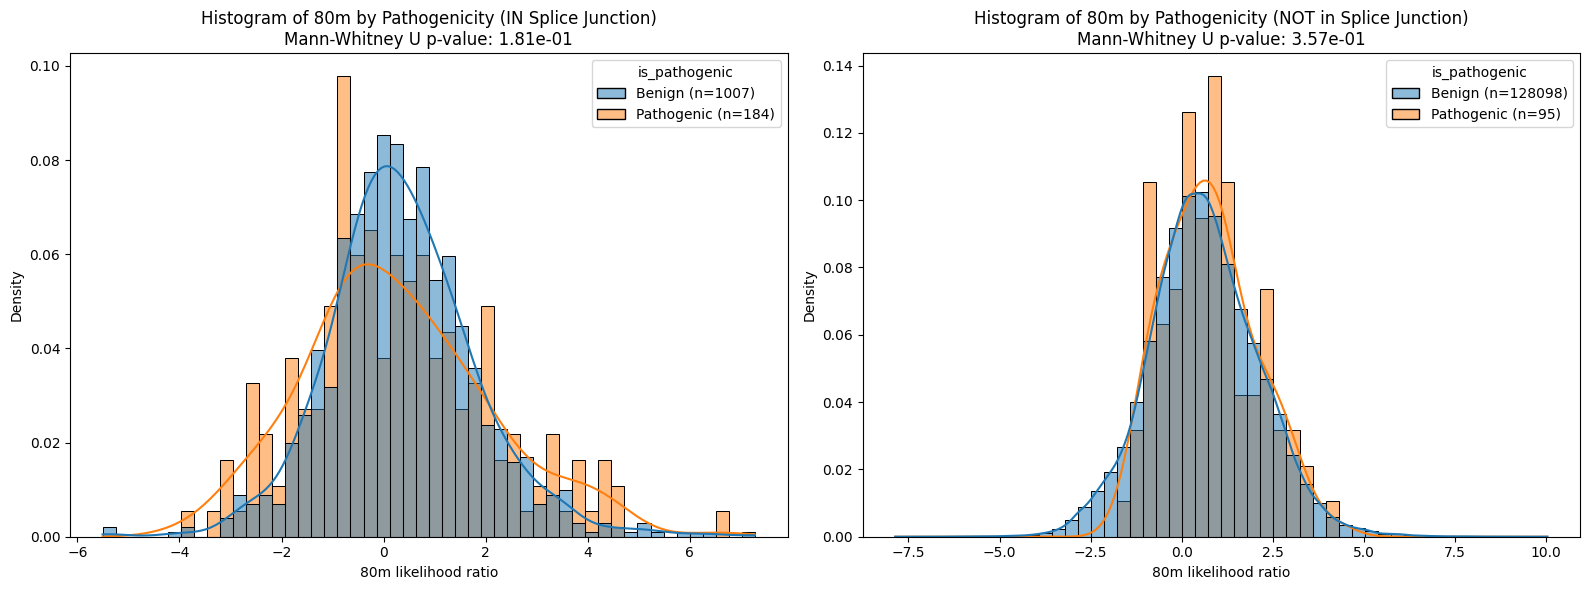

In [8]:
preds_cols = [col for col in dset.columns if col in MODEL_CHECKPOINTS.keys()]
# Create separate plots for each model
for model_name in preds_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    for j, (in_splice, ax) in enumerate(zip([True, False], [ax1, ax2])):
        # Filter data based on splice junction status
        filtered_data = dset.filter(pl.col("in_splice_junction") == in_splice).to_pandas()

        # Separate pathogenic and benign data (only from filtered data)
        pathogenic_data = filtered_data[filtered_data["is_pathogenic"] == 1][model_name].dropna()
        benign_data = filtered_data[filtered_data["is_pathogenic"] == 0][model_name].dropna()

        # Calculate Mann-Whitney U test
        p_value = None
        if len(pathogenic_data) > 0 and len(benign_data) > 0:
            _, p_value = mannwhitneyu(pathogenic_data, benign_data, alternative="two-sided")

        # Create histogram with custom labels
        sns.histplot(
            data=filtered_data,
            x=model_name,
            hue="is_pathogenic",
            hue_order=[0, 1],
            bins=50,
            kde=True,
            stat="proportion",
            common_norm=False,
            ax=ax,
        )

        # Update legend labels to match hue_order [0, 1] = [Benign, Pathogenic]
        # hue_order=[0, 1] means: 0=Benign (first), 1=Pathogenic (second)
        legend_labels = [f"Benign (n={len(benign_data)})", f"Pathogenic (n={len(pathogenic_data)})"]

        # Get the existing legend and update labels
        legend = ax.get_legend()
        if legend is not None:
            for idx, text in enumerate(legend.get_texts()):
                if idx < len(legend_labels):
                    text.set_text(legend_labels[idx])
        else:
            # If no legend exists, create one manually
            ax.legend(labels=legend_labels)

        # Set title and labels
        splice_status = "IN" if in_splice else "NOT in"
        title = f"Histogram of {model_name} by Pathogenicity ({splice_status} Splice Junction)"
        if p_value is not None:
            title += f"\nMann-Whitney U p-value: {p_value:.2e}"

        ax.set_title(title)
        ax.set_xlabel(f"{model_name} likelihood ratio")
        ax.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

In [9]:
dset.head()

id,chrom,pos,ref,alt,var_rel_dist_in_cds,codon_position,ref_codon,alt_codon,tx,label,in_splice_junction,ref_seq,alt_seq,ref_aa,alt_aa,ref_codon_freq,alt_codon_freq,codon_freq_ratio,gene_name,pli,pli_bin,phylop,phylop_bin,cds_length,cds_offset_frac,cds_offset_frac_bin,80m,is_pathogenic
i64,str,i64,str,str,i64,i64,str,str,str,str,bool,str,str,str,str,f64,f64,f64,str,f64,i64,f64,i64,i64,f64,i64,f64,i8
0,"""chr1""",45015006,"""G""","""A""",941,313,"""GAG""","""GAA""","""NM_000374.5""","""Likely pathogenic""",true,"""ATGGAAGCGAATGGGTTGGGACCTCAGGGT…","""ATGGAAGCGAATGGGTTGGGACCTCAGGGT…","""E""","""E""",4.6414453e7,3.7827281e7,0.20458,"""UROD""",0.0,0,7.998,8,1104,0.852355,8,1.1841149,1
1,"""chr10""",124400865,"""G""","""A""",1133,377,"""AAC""","""AAT""","""NM_000274.4""","""Benign""",false,"""ATGTTTTCCAAACTAGCACATTTGCAGAGG…","""ATGTTTTCCAAACTAGCACATTTGCAGAGG…","""N""","""N""",2.0900468e7,2.0353876e7,0.0265,"""OAT""",0.0,0,-2.351,-2,1320,0.858333,8,-1.123766,0
2,"""chr12""",102843648,"""T""","""A""",1196,398,"""GTA""","""GTT""","""NM_000277.3""","""Pathogenic""",false,"""ATGTCCACTGCGGTCCTGGAAAACCCAGGC…","""ATGTCCACTGCGGTCCTGGAAAACCCAGGC…","""V""","""V""",8.725178e6,1.3189619e7,-0.413217,"""PAH""",0.0,0,1.96,2,1359,0.880059,8,0.160462,1
3,"""chr7""",65967767,"""G""","""A""",1616,538,"""AGC""","""AGT""","""NM_000181.4""","""Pathogenic/Likely pathogenic""",false,"""ATGGCCCGGGGGTCGGCGGTTGCCTGGGCG…","""ATGGCCCGGGGGTCGGCGGTTGCCTGGGCG…","""S""","""S""",2.2875088e7,1.5825387e7,0.368433,"""GUSB""",0.0,0,2.034,2,1956,0.826176,8,0.398401,1
4,"""chr9""",137233722,"""G""","""A""",845,281,"""CCG""","""CCA""","""NM_001177316.2""","""Pathogenic/Likely pathogenic""",true,"""ATGCCGAGTTCCCTTCCCGGCAGCCAGGTC…","""ATGCCGAGTTCCCTTCCCGGCAGCCAGGTC…","""P""","""P""",7.888797e6,2.1390054e7,-0.997482,"""SLC34A3""",0.0,0,2.659,3,1800,0.469444,4,0.8169,1


Text(0.5, 1.0, 'Pathogenic all vs Benign all\nROC Score')

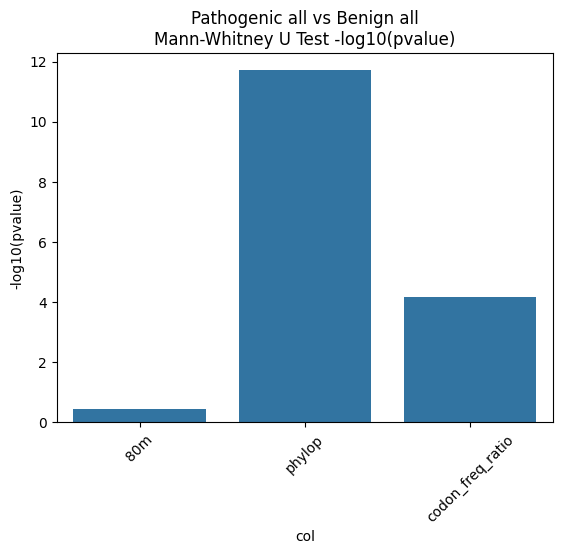

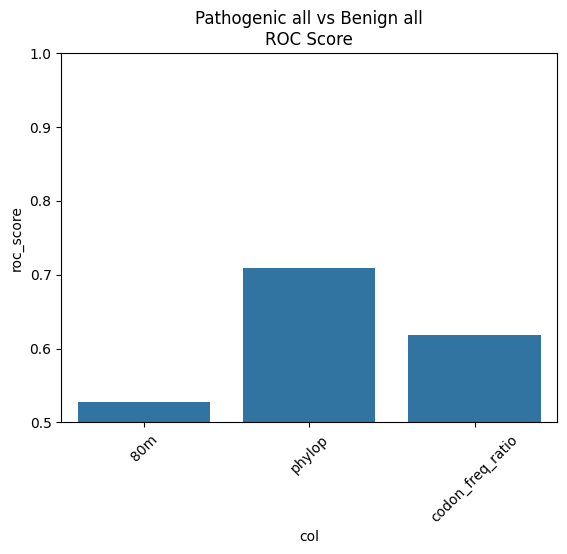

In [10]:
temp = dset.filter(~pl.col("in_splice_junction")).to_pandas()
temp["is_pathogenic"] = temp["is_pathogenic"].astype(bool)

mwu_scores = []

patho = temp.loc[temp["is_pathogenic"]]
non_patho = temp.loc[~temp["is_pathogenic"]]
for col in preds_cols + ["phylop", "codon_freq_ratio"]:
    roc_score = roc_auc_score(temp["is_pathogenic"], temp[col])
    mwu = mannwhitneyu(patho[col], non_patho[col])
    mwu_scores.append([col, mwu.pvalue, mwu.statistic, roc_score])

mwu_scores_df = pd.DataFrame(mwu_scores, columns=["col", "pvalue", "statistic", "roc_score"])
mwu_scores_df["-log10(pvalue)"] = -np.log10(mwu_scores_df["pvalue"])

plt.figure()
sns.barplot(x="col", y="-log10(pvalue)", data=mwu_scores_df)
plt.title("Pathogenic all vs Benign all\nMann-Whitney U Test -log10(pvalue)")
plt.xticks(rotation=45)
plt.figure()
plt.xticks(rotation=45)
sns.barplot(x="col", y="roc_score", data=mwu_scores_df)
plt.ylim(0.5, 1)
plt.title("Pathogenic all vs Benign all\nROC Score")

([0, 1, 2],
 [Text(0, 0, '80m'), Text(1, 0, 'phylop'), Text(2, 0, 'codon_freq_ratio')])

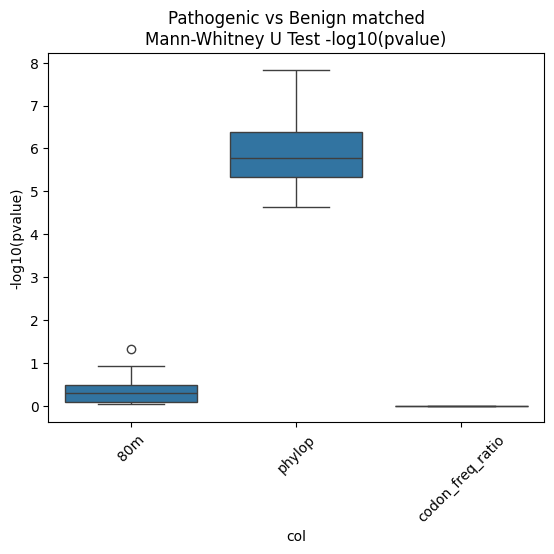

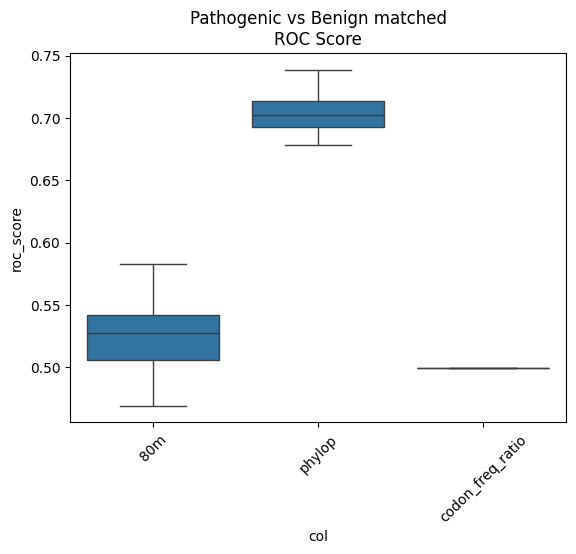

In [11]:
temp = dset.filter(~pl.col("in_splice_junction")).to_pandas()
temp["is_pathogenic"] = temp["is_pathogenic"].astype(bool)
temp["match_key"] = (
    temp["ref_codon"]
    + ">"
    + temp["alt_codon"]
    + ">"
    + temp["pli_bin"].astype(str)
    + ">"
    + temp["cds_offset_frac_bin"].astype(str)
)

mwu_scores = []

for _ in range(50):
    # Split into pathogenic and non-pathogenic
    patho = temp.loc[temp["is_pathogenic"]]
    non_patho = temp.loc[~temp["is_pathogenic"]]

    # Count trinuc_change in pathogenic
    patho_trinuc_counts = patho["match_key"].value_counts()

    sampled_non_patho = []
    for trinuc, count in patho_trinuc_counts.items():
        subset = non_patho[non_patho["match_key"] == trinuc]
        if len(subset) >= count:
            sampled = subset.sample(n=count)
        else:
            # print(f"Not enough {trinuc} in non-pathogenic data, taking all available")
            sampled = subset  # take all available if not enough
        sampled_non_patho.append(sampled)

    sampled_non_patho = pd.concat(sampled_non_patho, ignore_index=True)
    # Combine back with pathogenic
    temp_sampled = pd.concat([patho, sampled_non_patho], ignore_index=True)

    for col in preds_cols + ["phylop", "codon_freq_ratio"]:
        roc_score = roc_auc_score(temp_sampled["is_pathogenic"], temp_sampled[col])
        mwu = mannwhitneyu(patho[col], sampled_non_patho[col])
        mwu_scores.append([col, mwu.pvalue, mwu.statistic, roc_score])


mwu_scores_df = pd.DataFrame(mwu_scores, columns=["col", "pvalue", "statistic", "roc_score"])
mwu_scores_df["-log10(pvalue)"] = -np.log10(mwu_scores_df["pvalue"])
# mwu_scores_df = mwu_scores_df[mwu_scores_df['col'] != '1b_cdswt']
plt.figure()
sns.boxplot(x="col", y="-log10(pvalue)", data=mwu_scores_df)
plt.title("Pathogenic vs Benign matched\nMann-Whitney U Test -log10(pvalue)")
plt.xticks(rotation=45)
plt.figure()
sns.boxplot(x="col", y="roc_score", data=mwu_scores_df)
plt.title("Pathogenic vs Benign matched\nROC Score")
plt.xticks(rotation=45)